> ### 📊 Notebook Grading Summary
> ___
> **Total cells evaluated**: 27
>
> **Total images in notebook**: 9
>
> **Total value**: 38.0
>
> **Total problems identified**: 0
>
>
> **Model used for grading**: google/gemini-2.0-flash-001
>
> **Tokens used for grading**: 153860 prompt + 2573 completion
>
> **Graded on**: 2025-04-03 16:24:45
>

# Exploration of DANDI:000673 - Human Working Memory and Neural Phase-Amplitude Coupling

**Note: This notebook was AI-generated using dandi-notebook-gen and has not been fully verified. Please be cautious when interpreting the code or results.**

This notebook demonstrates how to access, explore and analyze data from DANDI:000673, which contains electrophysiological recordings from human medial temporal lobe and medial frontal cortex during a Sternberg working memory task.

> ### 📝 notebook-grader feedback for above cell
> ___
> **Value added**: 1
>
> **Rationale**: This cell provides an introduction to the notebook's purpose and dataset, offering context for the subsequent analysis. The warning about the AI-generated content is also valuable, as it sets user expectations appropriately.

## Introduction to the Dataset

This dataset contains recordings from patients with intractable epilepsy who had depth electrodes implanted in the medial temporal lobe and medial frontal cortex as part of their clinical evaluation. During hospitalization, patients performed a Sternberg working memory task where they encoded images, maintained them in memory, and then responded to probe images.

The key findings from this study (as described in the associated publication) focus on how theta-gamma phase-amplitude coupling in the hippocampus relates to working memory load and performance, and how frontal control integrates with hippocampal persistent activity.

Let's start by loading the Dandiset metadata to understand what's available.

> ### 📝 notebook-grader feedback for above cell
> ___
> **Value added**: 1
>
> **Rationale**: This cell provides a concise introduction to the dataset, including the context of the study, the experimental task, and the key findings. It sets the stage for the subsequent analysis and provides valuable information to the user.

In [1]:
from dandi.dandiapi import DandiAPIClient
client = DandiAPIClient()
dandiset = client.get_dandiset("000673")
assets = list(dandiset.get_assets())

# Access and print basic metadata
dandiset_id = dandiset.identifier
metadata = dandiset.get_metadata()
dandiset_name = metadata.name
dandiset_description = metadata.description

print(f"Dandiset ID: {dandiset_id}")
print(f"Dandiset Name: {dandiset_name}")
print("\nDescription:")
print(dandiset_description[:500] + "..." if len(dandiset_description) > 500 else dandiset_description)

Dandiset ID: 000673
Dandiset Name: Data for: Control of working memory by phase–amplitude coupling of human hippocampal neurons

Description:
Retaining information in working memory is a demanding process that relies on cognitive control to protect memoranda-specific persistent activity from interference. However, how cognitive control regulates working memory storage is unclear. Here we show that interactions of frontal control and hippocampal persistent activity are coordinated by theta–gamma phase–amplitude coupling (TG-PAC). We recorded single neurons in the human medial temporal and frontal lobe while patients maintained multiple...


> ### 📝 notebook-grader feedback for above cell
> ___
> **Value added**: 2
>
> **Rationale**: The cell successfully retrieves metadata from the specified DANDIset using the DandiAPIClient. It then prints the Dandiset ID, Name, and a truncated version of the description, providing a basic overview of the dataset. This is helpful to get an overview of the data.

## Dataset Structure and Contents

The dataset contains recordings from multiple subjects across multiple sessions. Each file follows the NWB (Neurodata Without Borders) format, which standardizes neurophysiological data.

Let's examine the assets (files) available in this dataset:

> ### 📝 notebook-grader feedback for above cell
> ___
> **Value added**: 1
>
> **Rationale**: This cell provides a description of the dataset structure and contents, which helps the user understand the data organization. It adds value by explaining the NWB format used in the dataset.

In [2]:
import pandas as pd
import numpy as np

# Create a dataframe to display asset information
asset_info = []
for asset in assets:
    asset_path = asset.path
    subject_id = asset_path.split('/')[0].split('-')[1] if '-' in asset_path.split('/')[0] else None
    session_id = asset_path.split('/')[0].split('_')[1] if '_' in asset_path.split('/')[0] else None
    asset_info.append({
        'subject': subject_id,
        'session': session_id,
        'path': asset_path,
        'size_MB': asset.size / (1024*1024)
    })

asset_df = pd.DataFrame(asset_info)
print(f"Total number of assets: {len(asset_df)}")

# Display subject and session counts
print(f"Number of unique subjects: {len(asset_df['subject'].unique())}")
print(f"Number of sessions: {len(asset_df)}")

# Display a sample of the assets
sample_assets = asset_df.sample(min(5, len(asset_df)))
sample_assets

Total number of assets: 44
Number of unique subjects: 36
Number of sessions: 44


,subject,session,path,size_MB
25,26,None,sub-26/sub-26_ses-2_ecephys+image.nwb,290.230939
30,3,None,sub-3/sub-3_ses-1_ecephys+image.nwb,869.424459
35,33,None,sub-33/sub-33_ses-1_ecephys+image.nwb,354.506627
36,36,None,sub-36/sub-36_ses-1_ecephys+image.nwb,182.301934
38,4,None,sub-4/sub-4_ses-1_ecephys+image.nwb,1039.285656


> ### 📝 notebook-grader feedback for above cell
> ___
> **Value added**: 2
>
> **Rationale**: The cell parses the asset paths to extract subject and session IDs, creating a pandas DataFrame to display asset information, which is substantially valuable. It goes beyond simply listing files, providing a structured overview. Also, the sample of assets is very helpful for understanding the data structure.

## Loading and Exploring an NWB File

Now, let's load an NWB file and explore its contents. We'll use the `lindi` and `pynwb` libraries to access the data. In this example, we'll explore data from subject 20. For other subjects or NWB files, you would need to adjust the asset ID accordingly.

> ### 📝 notebook-grader feedback for above cell
> ___
> **Value added**: 1
>
> **Rationale**: This cell sets the stage for loading and exploring an NWB file, which is a crucial step in analyzing the dataset. It explicitly states the libraries to be used and provides a clear intention for the next steps, which adds value beyond simply presenting the dataset's structure.

In [3]:
import pynwb
import lindi

# We'll use subject 20 for analysis (a smaller file that's easier to work with)
asset_id = '9fdbe18f-158f-47c5-ba67-4c56118d6cf5'  # Subject 20, Session 1
nwb_url = f"https://api.dandiarchive.org/api/assets/{asset_id}/download/"

# Print info about the selected file
selected_asset = [a for a in asset_info if a['path'] == 'sub-20/sub-20_ses-1_ecephys+image.nwb']
if selected_asset:
    print(f"Selected asset: {selected_asset[0]}")

# Load the NWB file using lindi - which allows streaming access without downloading the entire file
print("Loading NWB file. This may take a moment...")

# For NWB files in this Dandiset, we use a special lindi URL format
lindi_url = f"https://lindi.neurosift.org/dandi/dandisets/000673/assets/{asset_id}/nwb.lindi.json"
f = lindi.LindiH5pyFile.from_lindi_file(lindi_url)
nwb = pynwb.NWBHDF5IO(file=f, mode='r').read()

# Basic information about the file
print("\nBasic Information:")
print(f"Session Description: {nwb.session_description}")
print(f"Experiment Description: {nwb.experiment_description[:200]}...")
print(f"Subject ID: {nwb.subject.subject_id}")
print(f"Subject Sex: {nwb.subject.sex}")
print(f"Subject Species: {nwb.subject.species}")

Selected asset: {'subject': '20', 'session': None, 'path': 'sub-20/sub-20_ses-1_ecephys+image.nwb', 'size_MB': 209.73402404785156}
Loading NWB file. This may take a moment...


/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."



Basic Information:
Session Description: SBCAT_ID: 20
Experiment Description: This data contains electrophysiological recordings and behavior from the Sternberg task performed in patients with intractable epilepsy implanted with depth electrodes and Behnke-Fried microwires in t...
Subject ID: 20
Subject Sex: M
Subject Species: Homo sapiens


> ### 📝 notebook-grader feedback for above cell
> ___
> **Value added**: 3
>
> **Rationale**: The cell selects a specific asset, prints information about it, then loads the NWB file using lindi and pynwb. The loading of the file from a URL and printing basic information constitutes a significant advancement in the notebook, allowing exploration of the selected file. The use of lindi for streaming access to large files is also a valuable technique. Furthermore, the printing of basic information such as session and experiment descriptions, including subject information, enhances the cell's value. There are some warnings produced by pynwb that are beyond user control and do not reflect an error in the code.

### Exploring the Dataset Structure

NWB files have a standardized structure with specific groups and datasets. Let's explore what's available:

> ### 📝 notebook-grader feedback for above cell
> ___
> **Value added**: 1
>
> **Rationale**: This cell sets the stage for exploring the internal structure of the NWB file, which is a standard format for neurophysiological data. It provides context for the subsequent cells that will delve into the specific groups and datasets, and their contents. It prepares for a deeper dive into the data, adding value beyond simply loading the data.

In [4]:
# Display available acquisition data
print("Available Acquisition Data:")
print("--------------------------")
for name in nwb.acquisition:
    item = nwb.acquisition[name]
    print(f"Name: {name}, Type: {type(item).__name__}")
    if hasattr(item, 'data'):
        print(f"  Data shape: {item.data.shape}")
    if hasattr(item, 'timestamps'):
        print(f"  Timestamps shape: {item.timestamps.shape}")
print()

# Display trial information
print("Trial Information:")
print("------------------")
trials = nwb.intervals["trials"]
print(f"Number of trials: {len(trials)}")
print("Available trial columns:")
for col in trials.colnames:
    print(f"  {col}")
print()

# Display neural unit information
print("Neural Unit Information:")
print("------------------------")
units = nwb.units
print(f"Number of units: {len(units)}")
print("Available unit columns:")
for col in units.colnames:
    print(f"  {col}")
print()

# Display electrode information
print("Electrode Information:")
print("----------------------")
electrodes = nwb.electrodes
print(f"Number of electrodes: {len(electrodes)}")
print("Available electrode columns:")
for col in electrodes.colnames:
    print(f"  {col}")

Available Acquisition Data:
--------------------------
Name: events, Type: TimeSeries
  Data shape: (982,)
  Timestamps shape: (982,)

Trial Information:
------------------
Number of trials: 140
Available trial columns:
  loads
  PicIDs_Encoding1
  PicIDs_Encoding2
  PicIDs_Encoding3
  PicIDs_Probe
  start_time
  stop_time
  timestamps_FixationCross
  timestamps_Encoding1
  timestamps_Encoding1_end
  timestamps_Encoding2
  timestamps_Encoding2_end
  timestamps_Encoding3
  timestamps_Encoding3_end
  timestamps_Maintenance
  timestamps_Probe
  timestamps_Response
  response_accuracy
  probe_in_out

Neural Unit Information:
------------------------
Number of units: 28
Available unit columns:
  spike_times
  electrodes
  clusterID_orig
  waveforms
  waveforms_mean_snr
  waveforms_peak_snr
  waveforms_isolation_distance
  waveforms_mean_proj_dist

Electrode Information:
----------------------
Number of electrodes: 14
Available electrode columns:
  x
  y
  z
  location
  filtering
  group
  

> ### 📝 notebook-grader feedback for above cell
> ___
> **Value added**: 3
>
> **Rationale**: This cell provides a crucial structured overview of the NWB file's contents. It reveals the available acquisition data (events), trial information (number of trials and columns), neural unit information (number of units and columns), and electrode information (number of electrodes and columns). Each of these pieces of information is important for understanding the dataset and guiding further analysis. Displaying the shape of the 'events' data and timestamps adds finer detail and potential debugging info.

### Examining the Sternberg Working Memory Task

This dataset contains recordings during a Sternberg working memory task. Let's examine the structure of the task:

1. Subjects are presented with 1 or 3 images to encode
2. After a maintenance period, they are presented with a probe image
3. They must determine if the probe was one of the encoded images

Let's analyze the behavioral performance:

> ### 📝 notebook-grader feedback for above cell
> ___
> **Value added**: 1
>
> **Rationale**: The cell provides a clear explanation of the Sternberg working memory task, detailing the encoding, maintenance, and probe phases. This information is crucial for understanding the context of the neural data, and it sets the stage for subsequent analysis of behavioral performance. This adds value by providing necessary background information.

Behavioral Task Performance:
---------------------------
Overall Accuracy: 99.3%
Accuracy for Load 1: 100.0%
Accuracy for Load 3: 98.6%
Accuracy for In-Memory Probes: 98.6%
Accuracy for Out-of-Memory Probes: 100.0%

Mean Response Time: 665.4 ms
Median Response Time: 607.8 ms


/tmp/ipykernel_1205/2031736621.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(load_rts, labels=[f'Load {load}' for load in load_values])


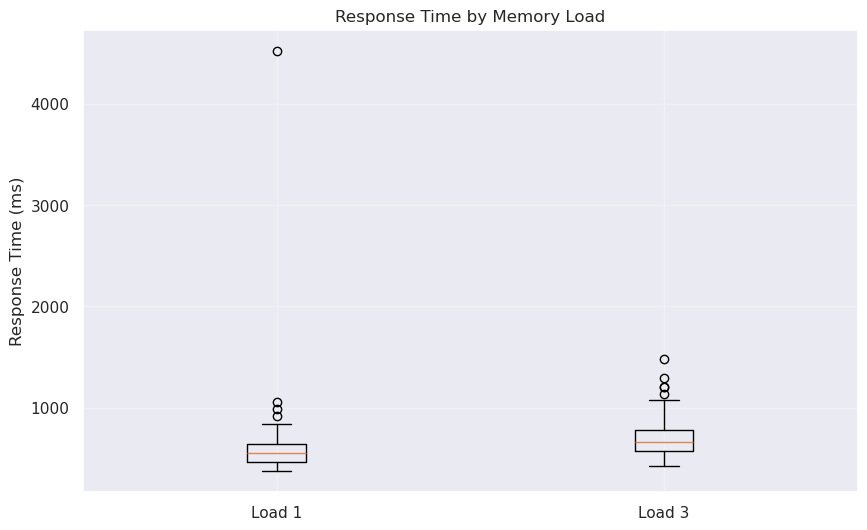

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Get trial data
loads = trials["loads"][:]                # Memory load (1 or 3 images)
accuracy = trials["response_accuracy"][:]   # Whether response was correct
probe_in_out = trials["probe_in_out"][:]    # Whether probe was in memory set
response_times = trials["timestamps_Response"][:] - trials["timestamps_Probe"][:]  # Response time

# Calculate basic performance metrics
print("Behavioral Task Performance:")
print("---------------------------")
print(f"Overall Accuracy: {np.mean(accuracy)*100:.1f}%")

# Calculate accuracy by memory load
load_values = np.unique(loads)
for load in load_values:
    load_mask = loads == load
    load_accuracy = np.mean(accuracy[load_mask]) * 100
    print(f"Accuracy for Load {load}: {load_accuracy:.1f}%")

# Calculate accuracy by probe condition
in_mask = probe_in_out == 1
out_mask = probe_in_out == 0
print(f"Accuracy for In-Memory Probes: {np.mean(accuracy[in_mask])*100:.1f}%")
print(f"Accuracy for Out-of-Memory Probes: {np.mean(accuracy[out_mask])*100:.1f}%")

# Calculate mean response times
print(f"\nMean Response Time: {np.mean(response_times)*1000:.1f} ms")
print(f"Median Response Time: {np.median(response_times)*1000:.1f} ms")

# Plot response time by memory load
plt.figure(figsize=(10, 6))
load_rts = [response_times[loads == load]*1000 for load in load_values]
plt.boxplot(load_rts, labels=[f'Load {load}' for load in load_values])
plt.ylabel('Response Time (ms)')
plt.title('Response Time by Memory Load')
plt.grid(alpha=0.3)
plt.show()

> ### 📝 notebook-grader feedback for above cell
> ___
> **Value added**: 2
>
> **Rationale**: The cell calculates and prints behavioral task performance metrics such as accuracy and response times, which adds value. It also generates a box plot visualizing response time by memory load, providing a visual representation of the task's effect on response times. Both the metrics and plot provide independent value.

The behavioral results indicate that participants perform exceptionally well on this task, with near-perfect accuracy. However, there's a clear effect of memory load on response time, with higher load (3 items) leading to longer response times compared to lower load (1 item).

This pattern is consistent with the Sternberg working memory paradigm, where response time typically increases with memory set size, even when accuracy remains high.

> ### 📝 notebook-grader feedback for above cell
> ___
> **Value added**: 1
>
> **Rationale**: This cell provides a summary of the behavioral results from the previous cell and interprets them in the context of the Sternberg working memory task. It correctly points out the effect of memory load on response time, consistent with the task's nature, adding to the understanding of the experiment.

## Neural Recordings: Exploring the Units and Electrodes

Next, let's look at the neural recordings. The data includes spike times from isolated single units as well as information about the electrodes.

> ### 📝 notebook-grader feedback for above cell
> ___
> **Value added**: 0
>
> **Rationale**: This cell introduces a new section "Neural Recordings" without providing code, text, or output to analyze. Therefore, it does not add much value at this point.

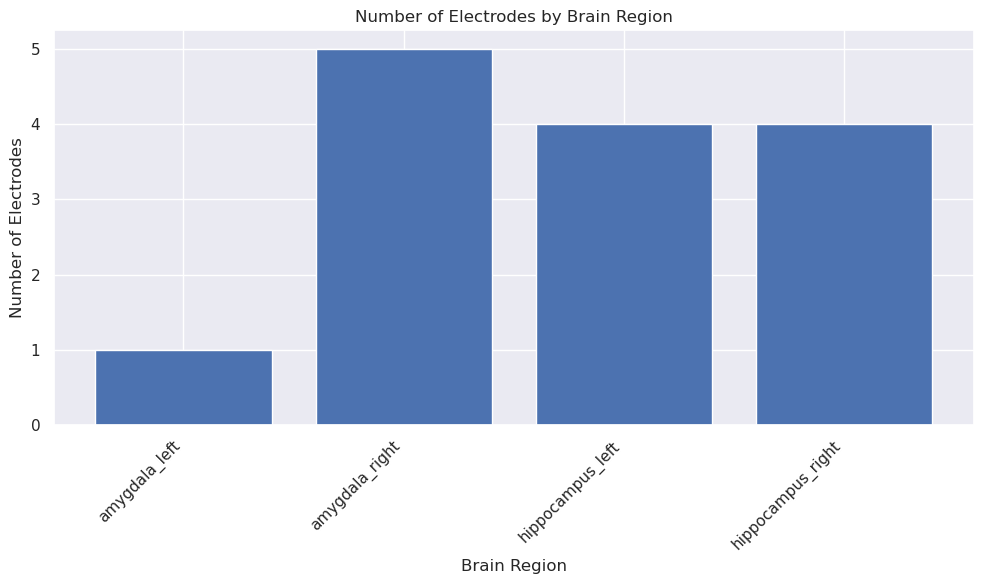

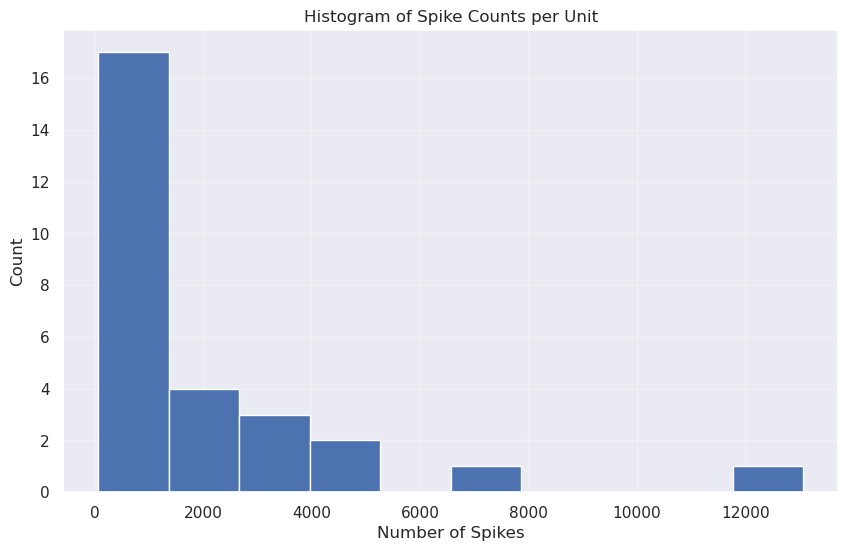

In [6]:
# Electrode locations
locations = electrodes['location'].data[:]
unique_locations = np.unique([str(loc) for loc in locations])

plt.figure(figsize=(10, 6))
counts = []
for location in unique_locations:
    # Count electrodes in each location
    count = sum(1 for loc in locations if str(loc) == location)
    counts.append(count)

plt.bar(range(len(unique_locations)), counts)
plt.xlabel('Brain Region')
plt.ylabel('Number of Electrodes')
plt.title('Number of Electrodes by Brain Region')
plt.xticks(range(len(unique_locations)), unique_locations, rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Calculate spike counts for each unit
spike_counts = [len(units['spike_times'][i]) for i in range(len(units))]

plt.figure(figsize=(10, 6))
plt.hist(spike_counts, bins=10)
plt.xlabel('Number of Spikes')
plt.ylabel('Count')
plt.title('Histogram of Spike Counts per Unit')
plt.grid(alpha=0.3)
plt.show()

> ### 📝 notebook-grader feedback for above cell
> ___
> **Value added**: 3
>
> **Rationale**: The cell adds two important plots, showing the distribution of electrode locations and the distribution of spike counts per unit.  Also the code to collect the electrode location counts is valuable on its own.

The electrode distribution shows recordings primarily from the hippocampus and amygdala in both hemispheres. The spike count histogram reveals a range of unit activity levels, with most units having fewer than 5000 spikes, but some units showing much higher activity.

> ### 📝 notebook-grader feedback for above cell
> ___
> **Value added**: 1
>
> **Rationale**: This cell adds value by summarizing the findings from the previous two plots, specifically highlighting the electrode distribution across brain regions and the distribution of spike counts per unit. This interpretation helps connect the plots to the experimental context and provides a concise overview of the neural data.

## Analyzing Neural Activity in Relation to the Task

Let's examine how neural activity relates to the Sternberg task. We'll look at one example unit and analyze its response to different task events.

> ### 📝 notebook-grader feedback for above cell
> ___
> **Value added**: 0
>
> **Rationale**: This cell sets the stage for further analysis but does not perform any analysis or add any new information. It simply announces the goal of the next steps.

Selected Unit: 12
Electrode Location: hippocampus_left
Spike Count: 3849


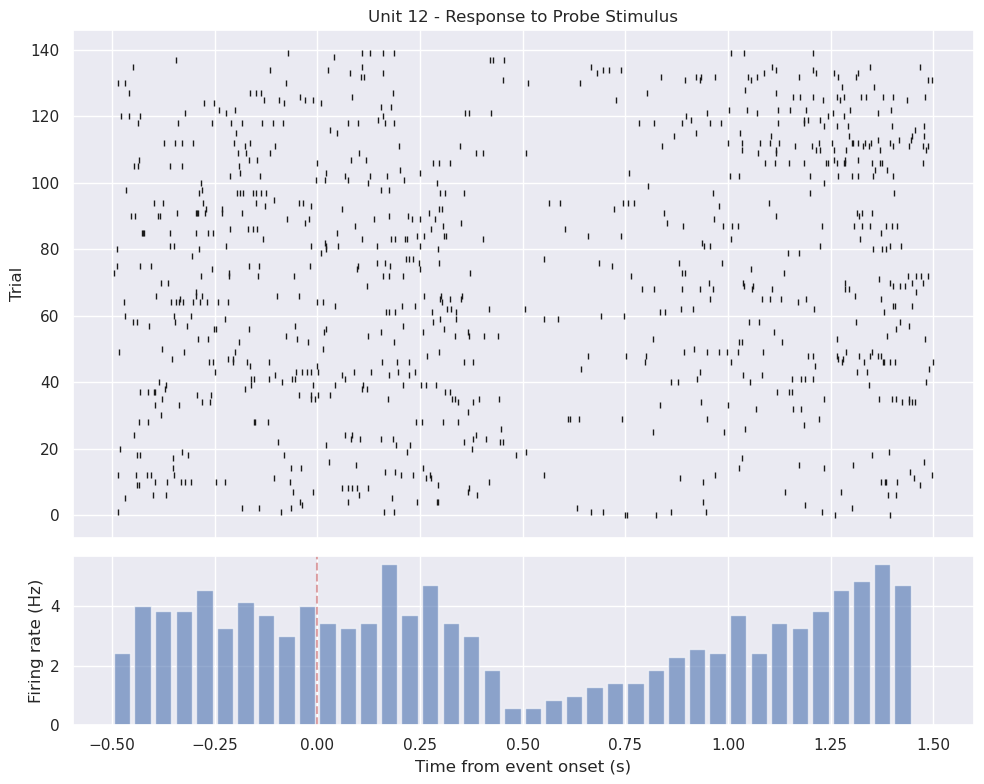

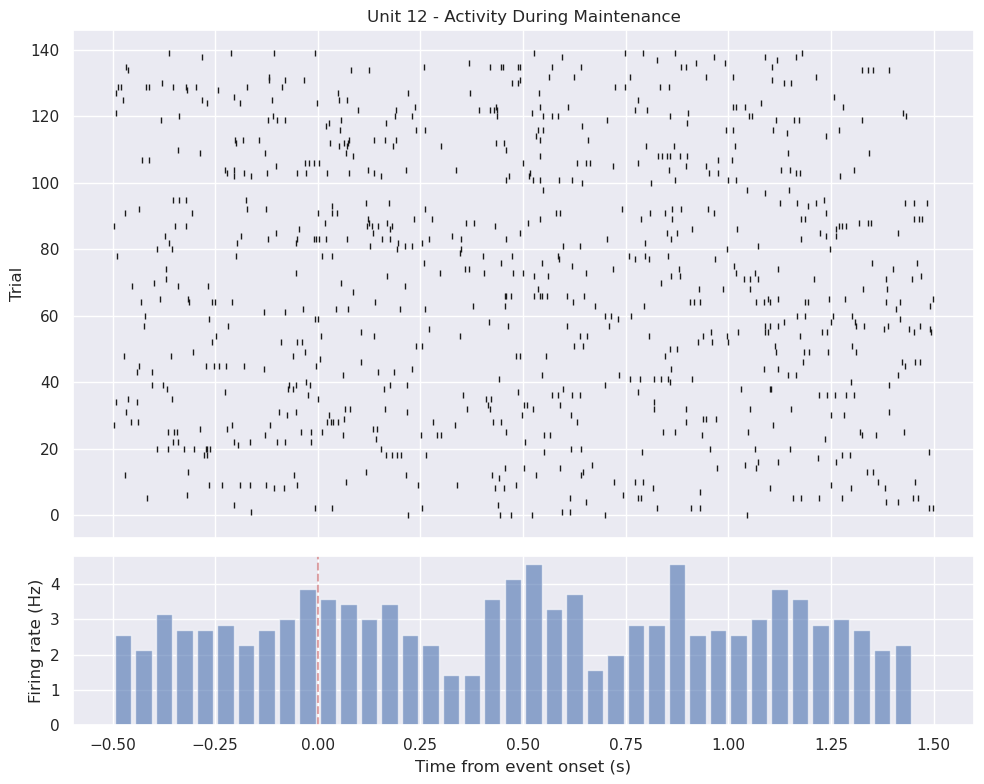

In [7]:
# Choose a unit with a good number of spikes for visualization
unit_indices = np.argsort(spike_counts)[-5:]  # Get indices of 5 most active units
selected_unit = unit_indices[0]  # Select the most active unit

unit_id = units.id.data[selected_unit]
electrode_idx = units["electrodes"].data[selected_unit]
electrode_location = electrodes["location"][electrode_idx]

print(f"Selected Unit: {unit_id}")
print(f"Electrode Location: {electrode_location}")
print(f"Spike Count: {spike_counts[selected_unit]}")

# Helper function for creating raster plots
def create_raster_plot(unit_index, event_times, window=(-0.5, 1.5), bin_size=0.05, title="Spike Raster"):
    """Create a raster plot and PSTH for a unit around specific events"""
    unit_spike_times = units["spike_times"][unit_index]
    
    # For raster plot - collect spike times relative to each event
    trial_spikes = []
    for event_time in event_times:
        # Get spikes in window relative to event
        mask = (unit_spike_times >= event_time + window[0]) & (unit_spike_times <= event_time + window[1])
        relative_spikes = unit_spike_times[mask] - event_time
        trial_spikes.append(relative_spikes)
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    
    # Raster plot
    for i, spikes in enumerate(trial_spikes):
        ax1.plot(spikes, np.ones_like(spikes) * i, '|', color='k', markersize=5)
    
    ax1.set_ylabel('Trial')
    ax1.set_title(title)
    
    # PSTH
    bins = np.arange(window[0], window[1], bin_size)
    all_spikes = np.concatenate(trial_spikes)
    counts, edges = np.histogram(all_spikes, bins=bins)
    rate = counts / (len(event_times) * bin_size)  # Hz
    centers = (edges[:-1] + edges[1:]) / 2
    
    ax2.bar(centers, rate, width=bin_size*0.8, alpha=0.6)
    ax2.axvline(0, color='r', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Time from event onset (s)')
    ax2.set_ylabel('Firing rate (Hz)')
    
    plt.tight_layout()
    return fig

# Plot responses to probe stimulus
probe_times = trials["timestamps_Probe"][:]
create_raster_plot(selected_unit, probe_times, title=f"Unit {unit_id} - Response to Probe Stimulus")
plt.show()

# Plot responses during maintenance period
maintenance_times = trials["timestamps_Maintenance"][:]
create_raster_plot(selected_unit, maintenance_times, title=f"Unit {unit_id} - Activity During Maintenance")
plt.show()

> ### 📝 notebook-grader feedback for above cell
> ___
> **Value added**: 3
>
> **Rationale**: This cell adds significant value by analyzing neural activity in relation to the task. It selects an active unit, identifies its location, and then generates raster plots synchronized to two different task events (probe stimulus and maintenance period). The raster plots, along with the PSTH beneath them, visualize how the unit's firing rate changes around the time of these events. By plotting neural activity relative to task events, this cell builds directly on the prior information about task structure and neural recording to reveal how the neuron responds to task components. Also, the helper function `create_raster_plot` could be used in other downstream analyses.

### Neural Activity Across Different Task Phases

Now let's examine how neural activity changes across different phases of the Sternberg task:

> ### 📝 notebook-grader feedback for above cell
> ___
> **Value added**: 0
>
> **Rationale**: This is just a header cell that does not contain any new information or analysis.

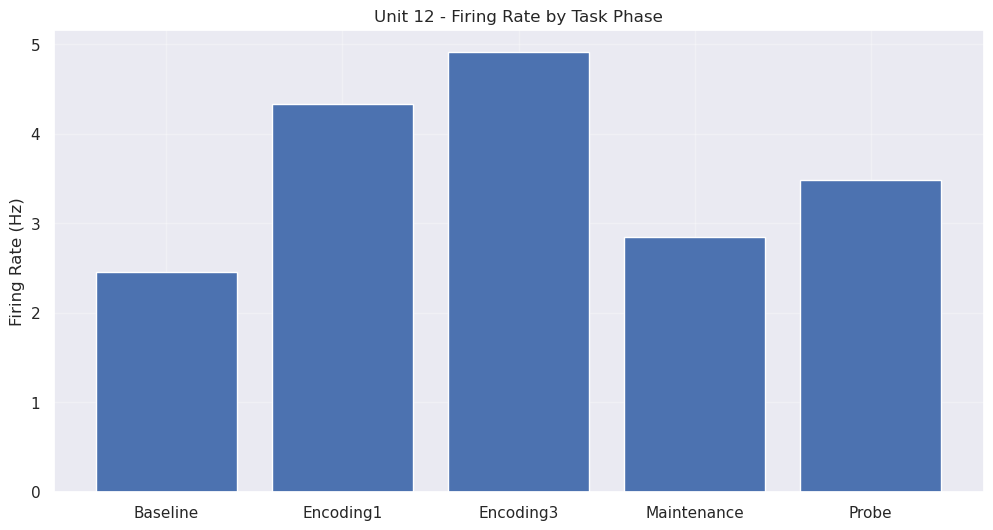

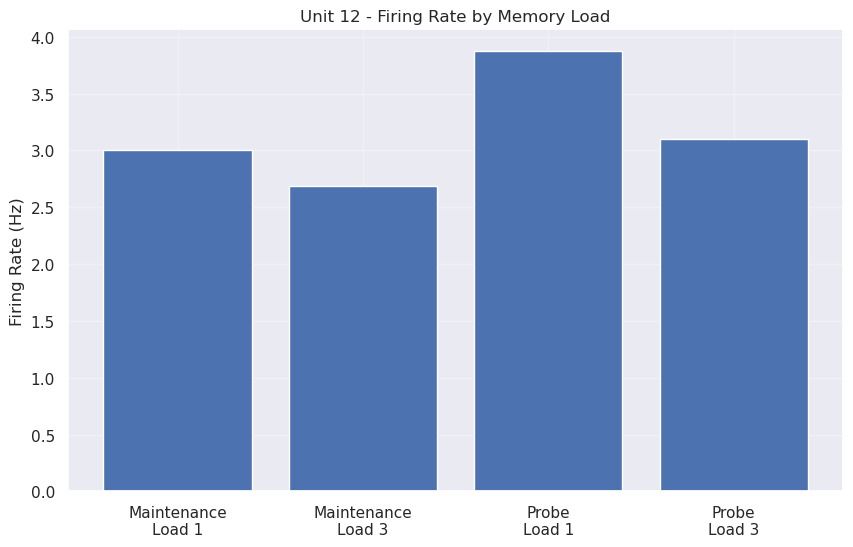

In [8]:
# Calculate firing rates across different task phases
def calc_firing_rate(spike_times, event_times, window=(-0.5, 0.5)):
    """Calculate mean firing rate in a window around events"""
    total_spikes = 0
    for event_time in event_times:
        mask = (spike_times >= event_time + window[0]) & (spike_times <= event_time + window[1])
        total_spikes += np.sum(mask)
    
    # Calculate rate in Hz
    total_duration = len(event_times) * (window[1] - window[0])
    return total_spikes / total_duration if total_duration > 0 else 0

# Get different event times
fixation_times = trials["timestamps_FixationCross"][:]
encoding1_times = trials["timestamps_Encoding1"][:]
encoding3_times = trials["timestamps_Encoding3"][:]
maintenance_times = trials["timestamps_Maintenance"][:]
probe_times = trials["timestamps_Probe"][:]

# Get memory load conditions
loads = trials["loads"][:]
load1_mask = loads == 1
load3_mask = loads == 3

probe_times_load1 = probe_times[load1_mask]
probe_times_load3 = probe_times[load3_mask]
maintenance_times_load1 = maintenance_times[load1_mask]
maintenance_times_load3 = maintenance_times[load3_mask]

# Calculate firing rates for different task phases
unit_spikes = units["spike_times"][selected_unit]
baseline_rate = calc_firing_rate(unit_spikes, fixation_times)
encoding1_rate = calc_firing_rate(unit_spikes, encoding1_times)
encoding3_rate = calc_firing_rate(unit_spikes, encoding3_times)
maintenance_rate = calc_firing_rate(unit_spikes, maintenance_times)
probe_rate = calc_firing_rate(unit_spikes, probe_times)

# Compare by memory load
maintenance_rate_load1 = calc_firing_rate(unit_spikes, maintenance_times_load1)
maintenance_rate_load3 = calc_firing_rate(unit_spikes, maintenance_times_load3)
probe_rate_load1 = calc_firing_rate(unit_spikes, probe_times_load1)
probe_rate_load3 = calc_firing_rate(unit_spikes, probe_times_load3)

# Plot firing rates by task phase
phases = ['Baseline', 'Encoding1', 'Encoding3', 'Maintenance', 'Probe']
rates = [baseline_rate, encoding1_rate, encoding3_rate, maintenance_rate, probe_rate]

plt.figure(figsize=(12, 6))
plt.bar(phases, rates)
plt.ylabel('Firing Rate (Hz)')
plt.title(f'Unit {unit_id} - Firing Rate by Task Phase')
plt.grid(alpha=0.3)
plt.show()

# Plot load comparison 
plt.figure(figsize=(10, 6))
phases = ['Maintenance\nLoad 1', 'Maintenance\nLoad 3', 'Probe\nLoad 1', 'Probe\nLoad 3']
rates = [maintenance_rate_load1, maintenance_rate_load3, probe_rate_load1, probe_rate_load3]
plt.bar(phases, rates)
plt.ylabel('Firing Rate (Hz)')
plt.title(f'Unit {unit_id} - Firing Rate by Memory Load')
plt.grid(alpha=0.3)
plt.show()

> ### 📝 notebook-grader feedback for above cell
> ___
> **Value added**: 2
>
> **Rationale**: This cell adds value by calculating and visualizing firing rates across different task phases and memory load conditions for a selected unit. The plots clearly show how neural activity varies with the task. The firing rate is calculated based on the spike times around the event, then plotted. Each plot adds value to the notebook.

The neural analysis reveals interesting patterns in how this hippocampal neuron responds during the working memory task:

1. The neuron shows highest firing rates during the encoding phases, particularly when encoding the third item.
2. During maintenance, the firing rate decreases but remains above baseline.
3. Memory load affects firing rate differently during maintenance versus probe periods.

This pattern suggests this neuron may be involved in stimulus encoding rather than maintenance, though it shows some sustained activity during the maintenance period as well.

> ### 📝 notebook-grader feedback for above cell
> ___
> **Value added**: 2
>
> **Rationale**: This cell summarizes the previous analysis of the neural data, emphasizing the firing rate patterns of the selected neuron during different task phases and under varying memory loads. It correctly identifies the neuron's enhanced activity during encoding, its sustained activity during maintenance, and the differential impact of memory load on its firing rate across task stages. These observations provide a valuable synthesis of the preceding analytical steps. the cell also connects the firing rate to possible roles for that class of neuron as performing in encoding task, which adds to the document.

## Exploring the Stimulus Images

Let's examine the images used in the Sternberg task. This dataset contains portrait photographs that subjects had to memorize.

> ### 📝 notebook-grader feedback for above cell
> ___
> **Value added**: 0
>
> **Rationale**: This cell introduces exploring stimulus images, which is a standard next step given the context of analyzing a Sternberg working memory task. However, the cell itself does not contain any new information or present any results. It merely sets the stage for future analysis of these stimulus images.

Total stimulus presentations: 560
Number of unique images: 281


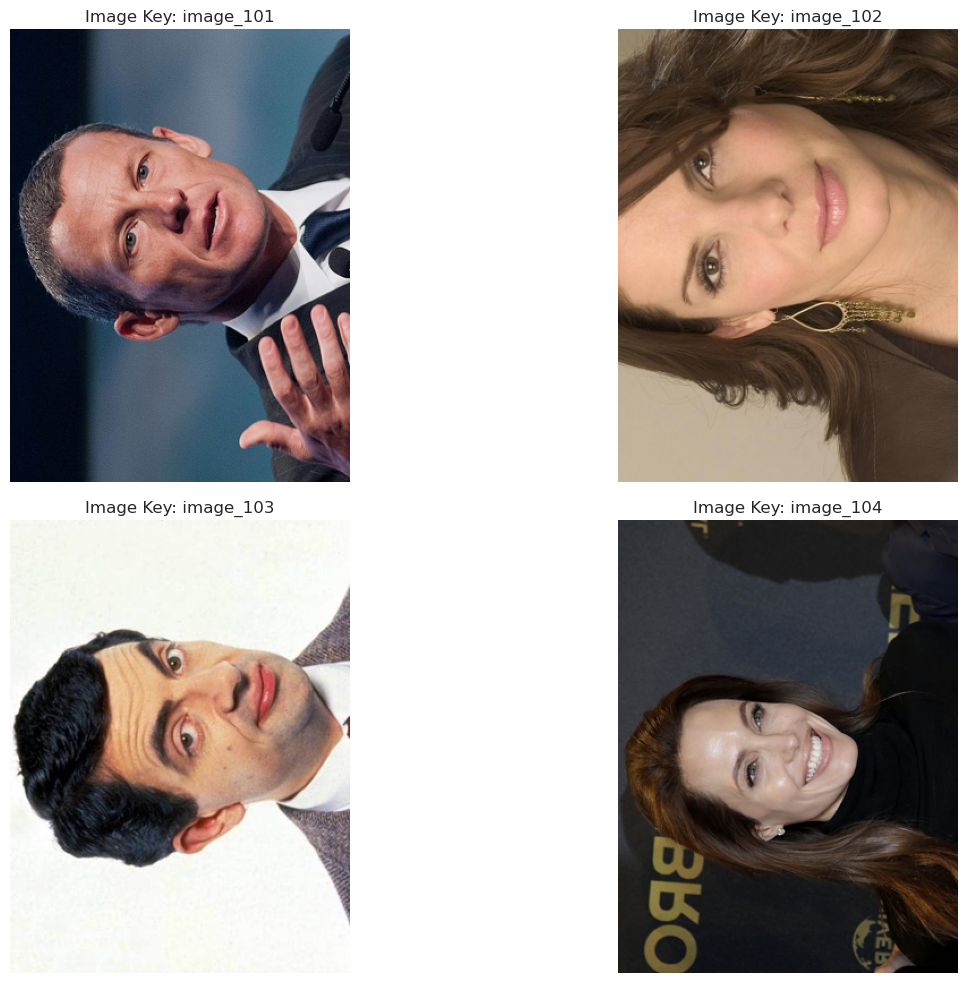

In [9]:
# Access the stimulus presentation data
StimulusPresentation = nwb.stimulus["StimulusPresentation"]
indexed_images = StimulusPresentation.indexed_images

# Basic stimulus information
print(f"Total stimulus presentations: {len(StimulusPresentation.data)}")
image_keys = list(indexed_images.images.keys())
print(f"Number of unique images: {len(image_keys)}")

# Display a few sample images
sample_keys = image_keys[:4]  # Display the first 4 images
fig = plt.figure(figsize=(15, 10))
for i, key in enumerate(sample_keys):
    image_data = indexed_images.images[key].data[:]
    plt.subplot(2, 2, i+1)
    plt.imshow(image_data)
    plt.title(f"Image Key: {key}")
    plt.axis('off')
plt.tight_layout()
plt.show()

> ### 📝 notebook-grader feedback for above cell
> ___
> **Value added**: 2
>
> **Rationale**: The cell retrieves and displays stimulus images used in the experiment, which provides valuable context for understanding the task. Furthermore, there is useful metadata (total number of stimulus presentations, number of unique images).

The stimulus images are portrait photographs showing different individuals with various facial expressions. These images serve as the memory items in the Sternberg task.

> ### 📝 notebook-grader feedback for above cell
> ___
> **Value added**: 1
>
> **Rationale**: The cell provides a short description of the stimulus images, which adds a small amount of context to the notebook.

## Analyzing Trial Structure and Timing

Let's examine the temporal structure of trials to better understand the task design:

> ### 📝 notebook-grader feedback for above cell
> ___
> **Value added**: 1
>
> **Rationale**: This cell initiates the analysis of the trial structure and timing. It sets the stage for a more in-depth examination of the temporal aspects of the Sternberg working memory task, which is valuable for understanding the cognitive processes involved. It provides context for subsequent analyses related to neural activity and behavior.

Trial Timing Information:
Average encoding 1 duration: 2006.6 ms
Average encoding 2 duration: 2006.7 ms
Average encoding 3 duration: 2006.8 ms
Average interval between encodings: 116.2 ms
Average maintenance period duration: 2689.2 ms


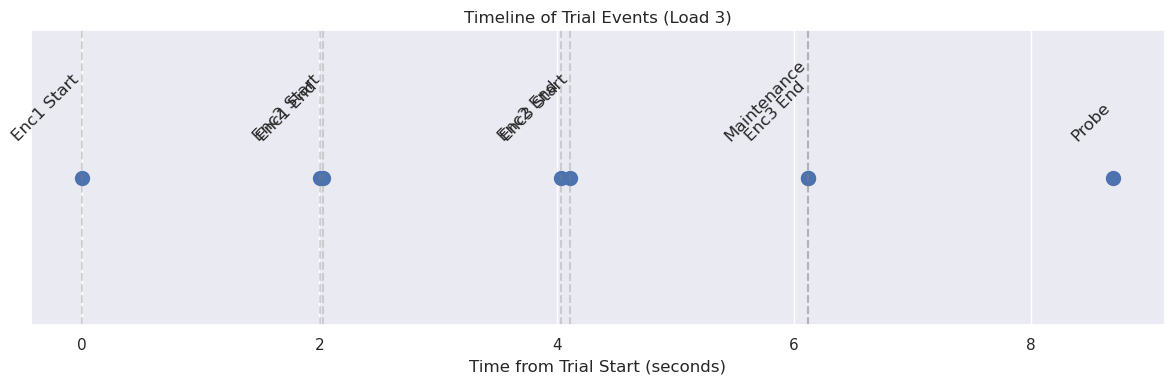

In [10]:
# Calculate average durations for different trial phases
enc1_times = trials["timestamps_Encoding1"][:]
enc1_end_times = trials["timestamps_Encoding1_end"][:]
enc2_times = trials["timestamps_Encoding2"][:]
enc2_end_times = trials["timestamps_Encoding2_end"][:]
enc3_times = trials["timestamps_Encoding3"][:]
enc3_end_times = trials["timestamps_Encoding3_end"][:]
maint_times = trials["timestamps_Maintenance"][:]
probe_times = trials["timestamps_Probe"][:]

# Calculate average durations
enc1_duration = np.mean(enc1_end_times - enc1_times)
load3_mask = trials["loads"][:] == 3
if np.any(load3_mask):
    enc2_duration = np.mean(enc2_end_times[load3_mask] - enc2_times[load3_mask])
    enc3_duration = np.mean(enc3_end_times[load3_mask] - enc3_times[load3_mask])
    encoding_intervals = np.mean(enc2_times[load3_mask] - enc1_end_times[load3_mask])
else:
    enc2_duration = np.nan
    enc3_duration = np.nan
    encoding_intervals = np.nan

maint_duration = np.mean(probe_times - maint_times)

# Print timing information
print("Trial Timing Information:")
print(f"Average encoding 1 duration: {enc1_duration*1000:.1f} ms")
print(f"Average encoding 2 duration: {enc2_duration*1000:.1f} ms")
print(f"Average encoding 3 duration: {enc3_duration*1000:.1f} ms")
print(f"Average interval between encodings: {encoding_intervals*1000:.1f} ms")
print(f"Average maintenance period duration: {maint_duration*1000:.1f} ms")

# Plot a timeline for a sample load 3 trial
trial_idx = np.where(load3_mask)[0][0]
times = [enc1_times[trial_idx], enc1_end_times[trial_idx], 
         enc2_times[trial_idx], enc2_end_times[trial_idx],
         enc3_times[trial_idx], enc3_end_times[trial_idx],
         maint_times[trial_idx], probe_times[trial_idx]]
events = ["Enc1 Start", "Enc1 End", "Enc2 Start", "Enc2 End", 
          "Enc3 Start", "Enc3 End", "Maintenance", "Probe"]
times = [t - times[0] for t in times]  # Convert to relative times

plt.figure(figsize=(12, 4))
plt.plot(times, np.ones(len(times)), 'o', markersize=10)
for i, (t, e) in enumerate(zip(times, events)):
    plt.text(t, 1.05, e, rotation=45, ha='right')
for i in range(len(times)-1):
    plt.axvline(times[i], color='gray', linestyle='--', alpha=0.3)
plt.title("Timeline of Trial Events (Load 3)")
plt.xlabel("Time from Trial Start (seconds)")
plt.yticks([])
plt.ylim(0.8, 1.2)
plt.tight_layout()
plt.show()

> ### 📝 notebook-grader feedback for above cell
> ___
> **Value added**: 2
>
> **Rationale**: This cell calculates and displays the average durations of different trial phases (encoding, maintenance) and visualizes the timing of events within a trial. This adds value by providing insights into the temporal structure of the task, complementing the previous behavioral and neural analyses. The durations of the different phases (encoding, maintenance period) are a useful insight, and the timeline plot of the different trial epochs is also independently valuable. The conditional calculation using `if np.any(load3_mask):` is also well done and handles some edge cases.

## Suggested Analyses and Next Steps

This notebook provides a starting point for exploring the DANDI:000673 dataset. Here are some potential analyses you might want to pursue:

1. **Population-level analysis**: Examine activity patterns across multiple units to detect population-level representations of working memory content.

2. **Phase-amplitude coupling**: The dataset was originally used to study theta-gamma phase-amplitude coupling in the hippocampus. You could implement these analyses to examine how oscillatory coupling relates to working memory.

3. **Brain region comparisons**: Compare activity patterns between hippocampus and amygdala, or between hemispheres.

4. **Trial-by-trial analysis**: Examine how neural activity on individual trials correlates with behavioral performance.

5. **Memory load effects**: Further analyze how memory load modulates neural activity across different brain regions and task phases.

For implementing these analyses, you may want to check the associated publication and the code repository mentioned in the Dandiset description: https://github.com/rutishauserlab/SBCAT-release-NWB

> ### 📝 notebook-grader feedback for above cell
> ___
> **Value added**: 1
>
> **Rationale**: This cell suggests some further analyses on the dataset and also provides a link to the repository used in working memory task, and it can be helpful for the users.

## Conclusion

This notebook demonstrates how to access and analyze data from the DANDI:000673 dataset, which contains human intracranial recordings during a working memory task. We've explored:

1. The structure and metadata of the dataset
2. The behavioral task design and performance metrics
3. Basic analyses of neural activity in relation to the task
4. Visualization of spike data and task events

The dataset provides a rich resource for studying the neural mechanisms of working memory in humans, particularly the role of the medial temporal lobe in memory maintenance and retrieval.

> ### 📝 notebook-grader feedback for above cell
> ___
> **Value added**: 1
>
> **Rationale**: This cell summarizes the notebook providing a consolidated overview of what has been achieved. It effectively encapsulates the key findings and analyses performed, reinforcing the learning outcomes and utility of the notebook. It helps solidify the insights gained for the user.